In [1]:
#64×64加工なしデータ×自作CNN（畳み込み６層）×SGD

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import japanize_matplotlib
from torchviz import make_dot
from torchinfo import summary
from IPython.display import display
from tqdm.notebook import tqdm
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cpu")
print(device)

cpu


In [3]:
!git clone https://github.com/makaishi2/pythonlibs.git

from pythonlibs.torch_lib1 import *

print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


In [4]:
!tree 加工なし画像

加工なし画像
├── test
│   ├── endo
│   │   ├── endo36.JPG
│   │   ├── endo37.JPG
│   │   ├── endo38.JPG
│   │   ├── endo39.JPG
│   │   ├── endo40.JPG
│   │   ├── endo41.JPG
│   │   ├── endo42.JPG
│   │   ├── endo43.JPG
│   │   ├── endo44.JPG
│   │   ├── endo45.JPG
│   │   ├── endo46.JPG
│   │   ├── endo47.JPG
│   │   ├── endo48.JPG
│   │   ├── endo49.JPG
│   │   └── endo50.JPG
│   ├── kaki
│   │   ├── kaki36.JPG
│   │   ├── kaki37.JPG
│   │   ├── kaki38.JPG
│   │   ├── kaki39.JPG
│   │   ├── kaki40.JPG
│   │   ├── kaki41.JPG
│   │   ├── kaki42.JPG
│   │   ├── kaki43.JPG
│   │   ├── kaki44.JPG
│   │   ├── kaki45.JPG
│   │   ├── kaki46.JPG
│   │   ├── kaki47.JPG
│   │   ├── kaki48.JPG
│   │   ├── kaki49.JPG
│   │   └── kaki50.JPG
│   ├── kubo
│   │   ├── kubo36.JPG
│   │   ├── kubo37.JPG
│   │   ├── kubo38.JPG
│   │   ├── kubo39.JPG
│   │   ├── kubo40.JPG
│   │   ├── kubo41.JPG
│   │   ├── kubo42.JPG
│   │   ├── kubo43.JPG
│   │   ├── kubo44.JPG
│   │   ├── kubo45.JPG
│   │   ├── kubo46.JPG
│ 

In [5]:
test_transform = transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),
                                     transforms.ToTensor(),transforms.Normalize(0.5, 0.5)])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),  transforms.Resize(64), transforms.CenterCrop(64),
                                      transforms.ToTensor(), transforms.Normalize(0.5, 0.5),
                                      transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)])

In [6]:
data_dir='加工なし画像'

import os
train_dir=os.path.join(data_dir,'train')
test_dir=os.path.join(data_dir,'test')

classes=['endo','kaki','kubo','nagi','yama']

n_output=len(list(set(classes)))

train_data=datasets.ImageFolder(train_dir,transform=train_transform)
train_data2=datasets.ImageFolder(train_dir,transform=test_transform)
test_data=datasets.ImageFolder(test_dir,transform=test_transform)

In [7]:
print(f' 学習データ:{len(train_data)}件')
print(f' 検証データ:{len(test_data)}件')

 学習データ:175件
 検証データ:75件


In [8]:
batch_size=10

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)

train_loader2=DataLoader(train_data2,batch_size=175,shuffle=True)

test_loader=DataLoader(test_data,batch_size=batch_size, shuffle=False)

test_loader2=DataLoader(test_data,batch_size=75,shuffle=True)

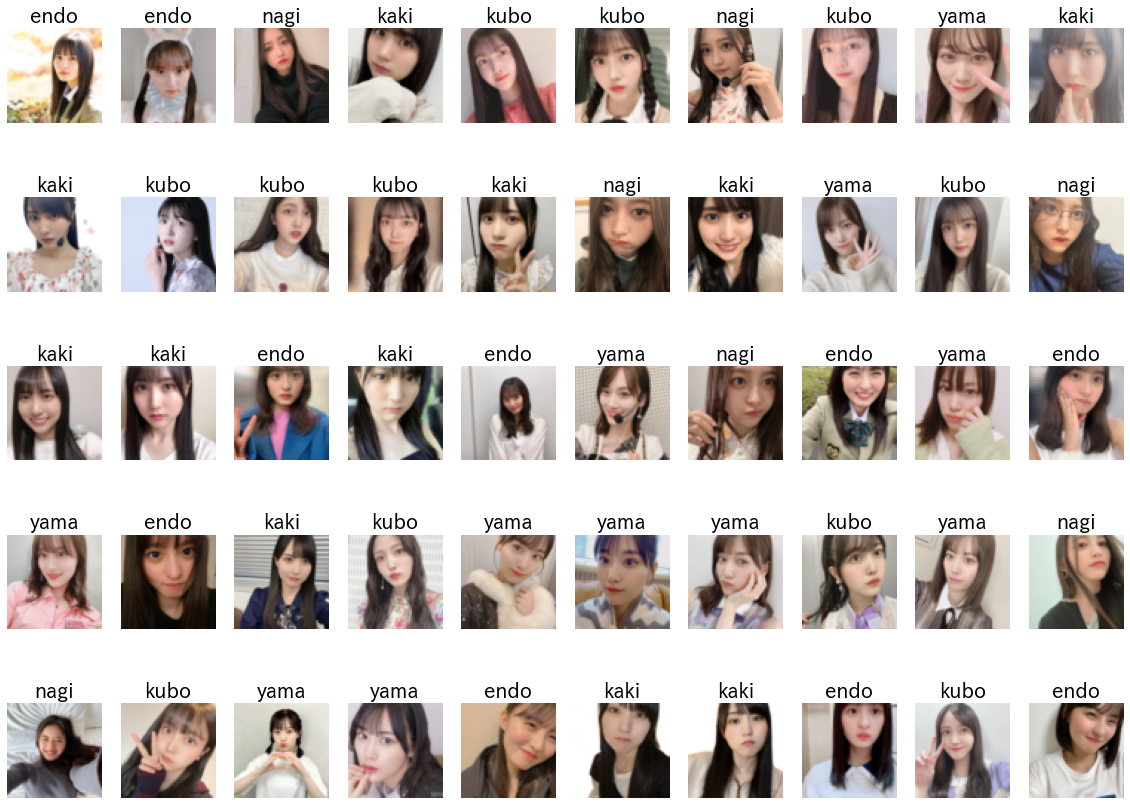

In [9]:
torch_seed()
show_images_labels(train_loader2,classes,None,None)

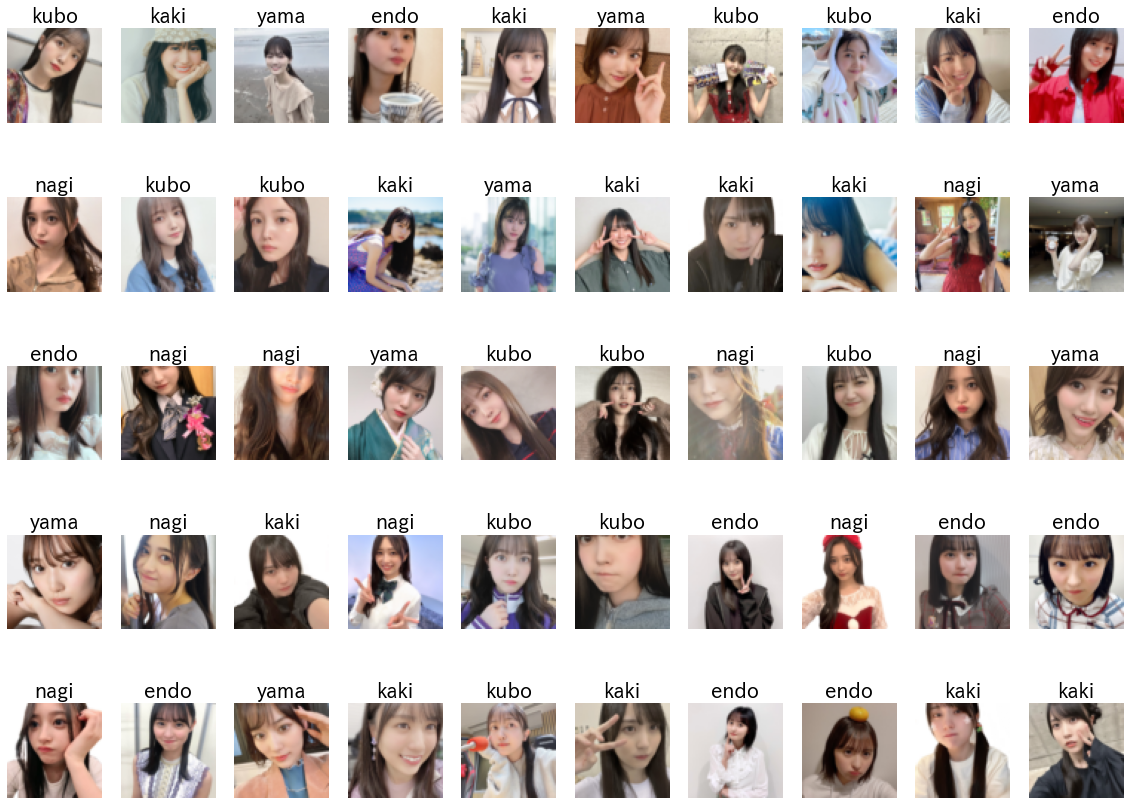

In [10]:
torch_seed()

show_images_labels(test_loader2, classes, None, None)

In [11]:
class CNN_v4(torch.nn.Module):
    def __init__(self,num_classes):
        
        super().__init__()
        
        self.conv1=torch.nn.Conv2d(3,64,3,padding=(1,1))
        self.conv2=torch.nn.Conv2d(64,64,3,padding=(1,1))
        self.conv3=torch.nn.Conv2d(64,128,3,padding=(1,1))
        self.conv4=torch.nn.Conv2d(128,128,3,padding=(1,1))
        self.conv5=torch.nn.Conv2d(128,256,3,padding=(1,1))
        self.conv6=torch.nn.Conv2d(256,256,3,padding=(1,1))
        self.relu=torch.nn.ReLU(inplace=True)
        self.flatten=torch.nn.Flatten()
        self.maxpool=torch.nn.MaxPool2d((2,2))
        self.l1=torch.nn.Linear(8*8*256,256)
        self.l2=torch.nn.Linear(256,10)
        self.dropout1=torch.nn.Dropout(0.2)
        self.dropout2=torch.nn.Dropout(0.3)
        self.dropout3=torch.nn.Dropout(0.4)
        self.bn1=torch.nn.BatchNorm2d(64)
        self.bn2=torch.nn.BatchNorm2d(64)
        self.bn3=torch.nn.BatchNorm2d(128)
        self.bn4=torch.nn.BatchNorm2d(128)
        self.bn5=torch.nn.BatchNorm2d(256)
        self.bn6=torch.nn.BatchNorm2d(256)
        
        self.features=torch.nn.Sequential(
            
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )
        
        self.classifier=torch.nn.Sequential(
            
            self.l1,
            self.relu,
            self.dropout3,
            self.l2,
        )
        
    def forward(self,x):
        x1=self.features(x)
        x2=self.flatten(x1)
        x3=self.classifier(x2)
        
        return x3

In [12]:
torch_seed()

net=CNN_v4(n_output).to(device)

criterion=torch.nn.CrossEntropyLoss()

lr=0.01

optimizer=optim.SGD(net.parameters(),lr=lr)

history=np.zeros((0, 5))

In [13]:
print(net)

CNN_v4(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=16384, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2)

In [14]:
num_epochs=30

history=fit(net,optimizer,criterion,num_epochs,train_loader,test_loader,device,history)

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [1/30], loss: 2.45774 acc: 0.17714 val_loss: 2.12376, val_acc: 0.20000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [2/30], loss: 1.81732 acc: 0.22857 val_loss: 1.82724, val_acc: 0.20000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [3/30], loss: 1.81183 acc: 0.19429 val_loss: 1.71900, val_acc: 0.20000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [4/30], loss: 1.71874 acc: 0.22857 val_loss: 1.69810, val_acc: 0.18667


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [5/30], loss: 1.70890 acc: 0.24000 val_loss: 1.68832, val_acc: 0.24000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [6/30], loss: 1.68874 acc: 0.28000 val_loss: 1.64927, val_acc: 0.21333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [7/30], loss: 1.57939 acc: 0.25143 val_loss: 1.70203, val_acc: 0.24000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [8/30], loss: 1.53375 acc: 0.30286 val_loss: 1.62647, val_acc: 0.29333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [9/30], loss: 1.56398 acc: 0.33714 val_loss: 1.52827, val_acc: 0.29333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [10/30], loss: 1.47975 acc: 0.33714 val_loss: 1.51257, val_acc: 0.41333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [11/30], loss: 1.53710 acc: 0.39429 val_loss: 1.50258, val_acc: 0.41333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [12/30], loss: 1.40426 acc: 0.39429 val_loss: 1.69826, val_acc: 0.28000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [13/30], loss: 1.42932 acc: 0.42286 val_loss: 1.52363, val_acc: 0.36000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [14/30], loss: 1.44980 acc: 0.41714 val_loss: 1.54918, val_acc: 0.36000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [15/30], loss: 1.35443 acc: 0.43429 val_loss: 1.49719, val_acc: 0.34667


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [16/30], loss: 1.21682 acc: 0.51429 val_loss: 1.49137, val_acc: 0.41333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [17/30], loss: 1.29428 acc: 0.45143 val_loss: 1.61944, val_acc: 0.36000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [18/30], loss: 1.34715 acc: 0.44571 val_loss: 1.64529, val_acc: 0.34667


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [19/30], loss: 1.26204 acc: 0.50857 val_loss: 1.52603, val_acc: 0.42667


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [20/30], loss: 1.21672 acc: 0.56000 val_loss: 1.89920, val_acc: 0.34667


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [21/30], loss: 1.13397 acc: 0.56571 val_loss: 1.49237, val_acc: 0.44000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [22/30], loss: 1.19378 acc: 0.52571 val_loss: 1.45981, val_acc: 0.40000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [23/30], loss: 1.10782 acc: 0.58286 val_loss: 2.23061, val_acc: 0.26667


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [24/30], loss: 1.27548 acc: 0.52000 val_loss: 1.58437, val_acc: 0.46667


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [25/30], loss: 1.10197 acc: 0.50286 val_loss: 1.46477, val_acc: 0.36000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [26/30], loss: 1.03956 acc: 0.56000 val_loss: 1.67796, val_acc: 0.37333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [27/30], loss: 1.06769 acc: 0.58857 val_loss: 1.46487, val_acc: 0.42667


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [28/30], loss: 1.02281 acc: 0.57143 val_loss: 1.79099, val_acc: 0.36000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [29/30], loss: 1.02693 acc: 0.60000 val_loss: 1.62658, val_acc: 0.42667


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [30/30], loss: 1.06047 acc: 0.60000 val_loss: 1.57913, val_acc: 0.41333


初期状態: 損失: 2.12376 精度: 0.20000
最終状態: 損失: 1.57913 精度: 0.41333


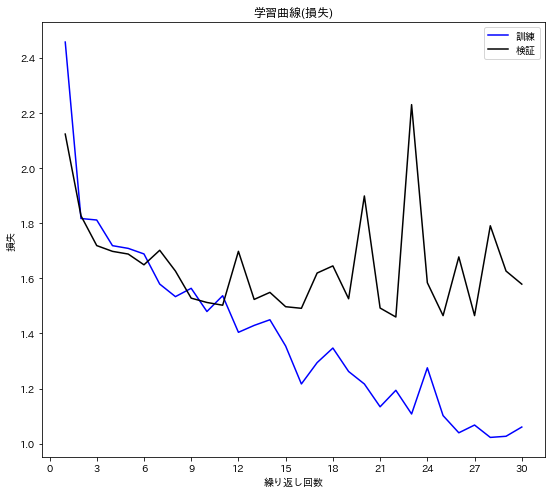

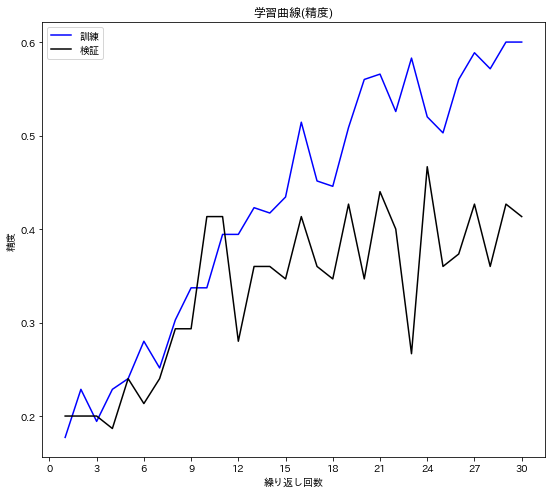

In [15]:
evaluate_history(history)

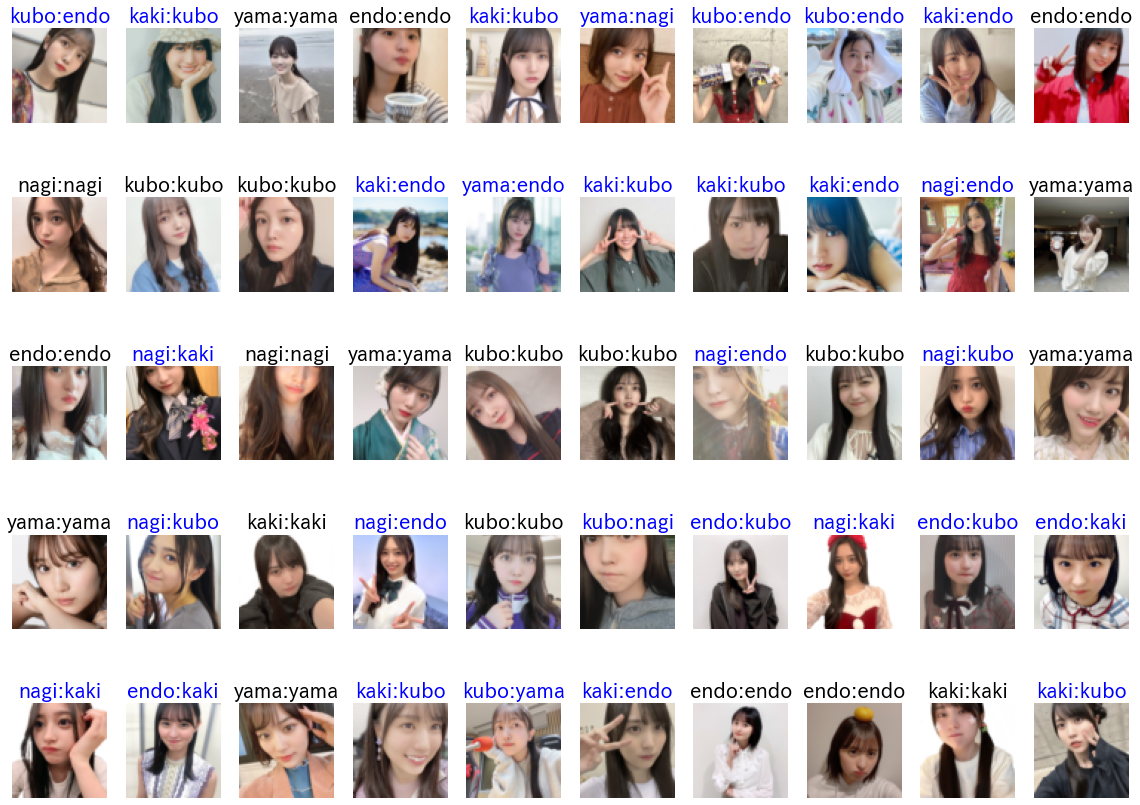

In [16]:
torch_seed()

show_images_labels(test_loader2,classes,net,device)